In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc, precision_score, recall_score, f1_score
import statsmodels.api as sm
import matplotlib.pyplot as plt 
import itertools
import math
from matplotlib import pyplot as plt
import seaborn as sns

In [5]:
df_smote = pd.read_excel("SMOTE_Undersampled_data.xlsx")

In [6]:
# df_smote = df_smote.drop('Unnamed: 0',axis=1)

In [7]:
df_smote


,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,y
0,47,0,109,1,0,22,268,1,-1,0,...,0,0,0,0,0,0,0,0,1,0
1,41,0,-41,1,1,3,154,1,-1,0,...,0,0,0,0,0,0,0,0,1,0
2,26,0,565,1,0,6,582,11,-1,0,...,1,0,0,0,0,0,0,0,1,0
3,33,0,621,0,0,8,217,1,-1,0,...,0,0,0,0,0,0,0,0,1,0
4,50,0,1260,0,0,18,172,1,-1,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,26,0,668,1,0,28,576,3,-1,0,...,0,0,1,0,0,0,0,0,1,1
1038,60,0,362,0,1,29,816,6,-1,0,...,0,0,0,0,0,0,0,0,1,1
1039,42,0,1080,1,1,13,951,3,370,4,...,0,0,1,0,0,0,0,0,0,1
1040,32,0,620,1,0,26,1234,3,-1,0,...,0,0,1,0,0,0,0,0,1,1


# Logistic regression model with categorical variables

In [ ]:

# Define independent variables by dropping 'y', and set the dependent variable
independent_var = df_smote.drop('y', axis=1).columns
dependent_var = 'y'

# Extract the features and target from df_encoded
X_all = df_smote[independent_var]
y_all = df_smote[dependent_var]

# Add a constant to the features
X_all = sm.add_constant(X_all)

# Build and fit the model
model = sm.Logit(y_all, X_all)
result_all = model.fit()

# Print the results
print(result_all.summary())


Optimization terminated successfully.
         Current function value: 0.384054
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1042
Model:                          Logit   Df Residuals:                      999
Method:                           MLE   Df Model:                           42
Date:                Mon, 11 Nov 2024   Pseudo R-squ.:                  0.4459
Time:                        12:16:12   Log-Likelihood:                -400.18
converged:                       True   LL-Null:                       -722.26
Covariance Type:            nonrobust   LLR p-value:                8.419e-109
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.2467      0.961     -0.257      0.798      -2.131       1.638
ag

Exclude all variables with p-value > 0.05

Rank them based on their significance

In [ ]:
p_values = result_all.pvalues
z_scores = result_all.tvalues 
coefficients = result_all.params

table = pd.DataFrame({
    'Variable': z_scores.index,
    'P-Value': p_values,
    'Z-Score': z_scores.abs(),
    'Coefficient': coefficients
})

sig_variables_table = table[table['P-Value'] <= 0.05]

sig_variables_table['Abs. Z-Score'] = sig_variables_table['Z-Score'].abs()
sorted_summary_table = sig_variables_table.sort_values(by='Abs. Z-Score', ascending=False)

# Display the sorted table
sorted_summary_table[['Abs. Z-Score', 'Coefficient']]

C:\Users\jedre\AppData\Local\Temp\ipykernel_5468\3386029679.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_variables_table['Abs. Z-Score'] = sig_variables_table['Z-Score'].abs()


,Abs. Z-Score,Coefficient
duration,13.683809,0.006076
contact_unknown,4.842790,-1.540391
poutcome_success,4.781726,3.338353
loan,3.580547,-1.087789
campaign,3.113724,-0.142540
month_mar,2.890362,2.436698
month_oct,2.860219,1.908100
month_nov,2.651821,-1.100276
month_jul,2.399524,-0.927096
job_blue-collar,2.312482,-0.834452


Transform coefficient into log odds -> into probability

In [ ]:
import numpy as np
pd.set_option('display.max_colwidth', None) # Show full column content

#sorted_summary_table` with the percentage change in odds
sorted_summary_table['Prob. Change (%)'] = (np.exp(sorted_summary_table['Coefficient']) - 1) * 100

# Interpretation
sorted_summary_table['Interpretation'] = sorted_summary_table.apply(
    lambda row: f"Increasing {row.name} by unit increases prob. of subscribing by {row['Prob. Change (%)']:.2f}%" 
                if row['Coefficient'] > 0 
                else f"Increasing {row.name} by unit decreases prob. of subscribing by {abs(row['Prob. Change (%)']):.2f}%",
    axis=1
)
sorted_summary_table[['Coefficient', 'Prob. Change (%)', 'Interpretation']]

,Coefficient,Prob. Change (%),Interpretation
duration,0.006076,0.609441,Increasing duration by unit increases prob. of subscribing by 0.61%
contact_unknown,-1.540391,-78.570271,Increasing contact_unknown by unit decreases prob. of subscribing by 78.57%
poutcome_success,3.338353,2717.269905,Increasing poutcome_success by unit increases prob. of subscribing by 2717.27%
loan,-1.087789,-66.303920,Increasing loan by unit decreases prob. of subscribing by 66.30%
campaign,-0.142540,-13.284734,Increasing campaign by unit decreases prob. of subscribing by 13.28%
month_mar,2.436698,1043.521787,Increasing month_mar by unit increases prob. of subscribing by 1043.52%
month_oct,1.908100,574.026756,Increasing month_oct by unit increases prob. of subscribing by 574.03%
month_nov,-1.100276,-66.722080,Increasing month_nov by unit decreases prob. of subscribing by 66.72%
month_jul,-0.927096,-60.429893,Increasing month_jul by unit decreases prob. of subscribing by 60.43%
job_blue-collar,-0.834452,-56.588783,Increasing job_blue-collar by unit decreases prob. of subscribing by 56.59%


To "check" the probability change with dummy variables

In [1]:
def calculate_probability_change(variable_name):
    baseline = X_all.mean()
    baseline[variable_name] = 0  # without the variable

    # Predicted prob without the variable
    prob_without_variable = result_all.predict(baseline)

    # Adjust the variable to 1 to see the effect
    baseline[variable_name] = 1
    prob_with_variable = result_all.predict(baseline)

    # Prob. difference
    probability_change = prob_with_variable.iloc[0] - prob_without_variable.iloc[0]
    print(f"Probability change when {variable_name} is 'yes': {probability_change * 100:.3f}%")


calculate_probability_change('duration')

NameError: name 'X_all' is not defined

#### Further analysis

In [ ]:
print(result_all.aic)
print(f'Chi-square of Omnibus Test: {result_all.llr:.4f}')
print(f'p-value of Omnibus Test: {result_all.llr_pvalue:.4f}')

import math
print(f'model-log: {result_all.llf:.4f}')
print(f'null-log: {result_all.llnull:.4f}')
print(f'McFadden_pseudo_R_squared:', 1-(result_all.llf/result_all.llnull))
print('Cox_Snells_pseudo_R_squared:', 1 - math.exp((result_all.llnull - result_all.llf)*(2/result_all.nobs)))

886.3680877957408
Chi-square of Omnibus Test: 644.1506
p-value of Omnibus Test: 0.0000
model-log: -400.1840
null-log: -722.2594
McFadden_pseudo_R_squared: 0.4459275090457303
Cox_Snells_pseudo_R_squared: 0.4610792720068876


In [ ]:
y_pred_all = result_all.predict(X_all)

prediction_all = list(map(round, y_pred_all)) 

print('Actual values', list(y_all.values)) 
print('Predictions :', prediction_all) 

Actual values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Accuracy: 0.8349


Text(0.5, 1.0, 'Confusion Matrix - SMOTE Oversampling Data')

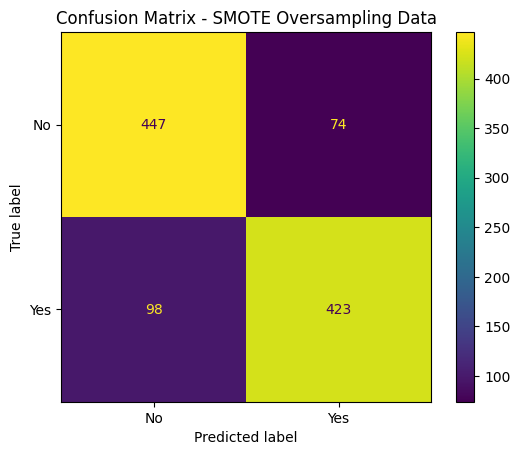

In [ ]:
# Evaluate the model for full-file
accuracy = accuracy_score(y_all, prediction_all)
print(f'Accuracy: {accuracy:.4f}')

labels = ['No', 'Yes']
conf_matrix = confusion_matrix(y_all.values, prediction_all)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=labels)
ax = disp.plot()
ax.ax_.set_title("Confusion Matrix - SMOTE Oversampling Data")

In [ ]:
class_report = classification_report(y_all.values, prediction_all)
print('Classification Report:')
print(class_report)

tn, fp, fn, tp = confusion_matrix(y_all.values, prediction_all).ravel()
# Calculate precision, recall, and F1 score directly
precision = precision_score(y_all.values, prediction_all)
recall = recall_score(y_all.values, prediction_all)
f1 = f1_score(y_all.values, prediction_all)

# Calculate metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
err = (fp + fn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)  
specificity = tn / (tn + fp)
precision = tp / (tp + fp)

# Print calculated metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Error Rate: {err:.4f}')
print(f'Recall (Sensitivity) True Positive Rate (TPR): {sensitivity:.4f}')
print(f'(Specificity) True Negative Rate (TNR): {specificity:.4f}')
print(f'Precision: {precision:.4f}')
print(f'f1 score: {f1:.4f}')

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       521
           1       0.85      0.81      0.83       521

    accuracy                           0.83      1042
   macro avg       0.84      0.83      0.83      1042
weighted avg       0.84      0.83      0.83      1042

Accuracy: 0.8349
Error Rate: 0.1651
Recall (Sensitivity) True Positive Rate (TPR): 0.8119
(Specificity) True Negative Rate (TNR): 0.8580
Precision: 0.8511
f1 score: 0.8310


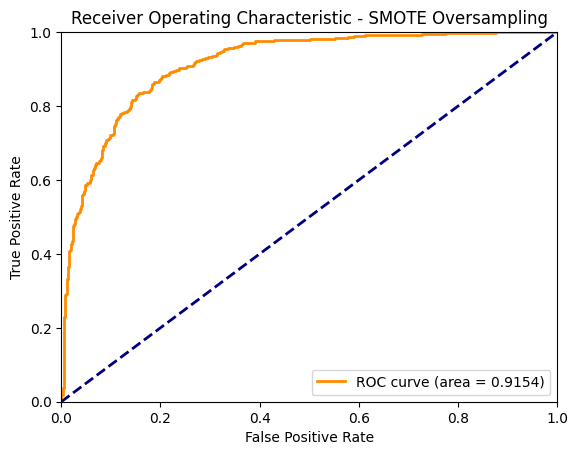

In [ ]:
fpr, tpr, thresholds = roc_curve(list(df_smote.y), y_pred_all, pos_label=1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - SMOTE Oversampling')
plt.legend(loc='lower right')
plt.show()